Importing all of our necessary libraries in order to properly explore our libraries including tools such as pandas, numpy, seaborn, etc. 

In [284]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

ramen = pd.read_csv(r"C:\Users\tyler\Downloads\ramen-ratings.csv")

In [285]:
print(ramen.head())
columns = list(ramen)
print(ramen.describe())
print(ramen.Stars)
print(ramen['Top Ten'].unique())

   Review #           Brand  \
0      2580       New Touch   
1      2579        Just Way   
2      2578          Nissin   
3      2577         Wei Lih   
4      2576  Ching's Secret   

                                             Variety Style Country Stars  \
0                          T's Restaurant Tantanmen    Cup   Japan  3.75   
1  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack  Taiwan     1   
2                      Cup Noodles Chicken Vegetable   Cup     USA  2.25   
3                      GGE Ramen Snack Tomato Flavor  Pack  Taiwan  2.75   
4                                    Singapore Curry  Pack   India  3.75   

  Top Ten  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
          Review #
count  2580.000000
mean   1290.500000
std     744.926171
min       1.000000
25%     645.750000
50%    1290.500000
75%    1935.250000
max    2580.000000
0       3.75
1          1
2       2.25
3       2.75
4       3.75
        ... 
2575     3.5
2576       1
2577     

Converting categorical features into binary variables to prepare for regression analysis. The Style column is encoded into binary values, along with Packaging and Region/Continent in which the product was manufactured. These dummy variables will allow us to include categorical data in the regression model and will serve as key predictors for later analysis.

In [287]:
style_binary_values = pd.get_dummies(ramen.Style)

In [289]:
country_names = ramen.Country.unique()
print(country_names)

def assign_region(country: str) -> str:

    # Define regions as a dictionary for better maintainability
    regions = {
        'North America': ['USA', 'United States', 'Mexico', 'Canada'],
        'South America': ['Colombia', 'Brazil'],
        'Asia': [
            'Pakistan', 'Vietnam', 'Japan', 'Taiwan', 'South Korea', 'Singapore', 
            'Thailand', 'Hong Kong', 'Myanmar', 'Nepal', 'Malaysia', 'Singapore', 
            'China', 'Sarawak', 'Phillipines', 'Dubai'
        ],
        'Europe': ['Germany', 'Hungary', 'Holland', 'Poland', 'Finland'],
        'Africa': ['Ghana']
    }
    
    # Check each region for the country
    for region, countries in regions.items():
        if country in countries:
            return region
    
    # Default to Oceania if not found in any other region
    return 'Oceania'

# Apply the function to create the Region column
ramen['Region'] = ramen.Country.apply(assign_region)

# Create dummy variables for the Region column
region_values = pd.get_dummies(ramen.Region)

['Japan' 'Taiwan' 'USA' 'India' 'South Korea' 'Singapore' 'Thailand'
 'Hong Kong' 'Vietnam' 'Ghana' 'Malaysia' 'Indonesia' 'China' 'Nigeria'
 'Germany' 'Hungary' 'Mexico' 'Fiji' 'Australia' 'Pakistan' 'Bangladesh'
 'Canada' 'Nepal' 'Brazil' 'UK' 'Myanmar' 'Netherlands' 'United States'
 'Cambodia' 'Finland' 'Sarawak' 'Philippines' 'Sweden' 'Colombia'
 'Estonia' 'Holland' 'Poland' 'Dubai']


In [290]:
#Defining Functions which would categorize the ramen into various flavors such as whether it's spicy, chicken, beef, pork, etc. 

def spicy_indicator(x): 
    if 'Spicy' in x or 'Hot' in x: 
        return 1
    else: 
        return 0
def chicken_indicator(x): 
    if 'Chicken' in x: 
        return 1
    else: return 0 
    
def pork_indicator(x):
    if 'Pork' in x: 
        return 1
    else:
        return 0 
    
def beef_indicator(x): 
    if 'Beef' in x or 'Oxtain' in x:
        return 1 
    else: 
        return 0 
    
def other_indicator(x): 
    if 'Chicken' in x:
        return 0 
    elif 'Beef' in x: 
        return 0 
    elif 'Pork' in x: 
        return 0 
    else: 
        return 1

ramen['Spicy'] = ramen.Variety.apply(func = spicy_indicator)
ramen['Chicken'] = ramen.Variety.apply(func = chicken_indicator)
ramen['Beef'] = ramen.Variety.apply(func = beef_indicator)
ramen['Pork'] = ramen.Variety.apply(func = pork_indicator)
ramen['Other'] = ramen.Variety.apply(func = other_indicator)

print('Number of Beef Ramen Products Reviewed:', ramen.Beef.sum())
print('Number of Chicken Ramen Products Reviewed:', ramen.Chicken.sum())
print('Number of Pork Ramen Products Reviewed:', ramen.Pork.sum())
print('Ramen Products Reviewed of Other Flavors:', ramen.Other.sum())

Number of Beef Ramen Products Reviewed: 232
Number of Chicken Ramen Products Reviewed: 323
Number of Pork Ramen Products Reviewed: 102
Ramen Products Reviewed of Other Flavors: 1924


In [291]:
#Joining all the variables into one singular DataFrame

ramen = pd.concat([ramen, style_binary_values, region_values], ignore_index = False, axis=1)
print(list(ramen))

['Review #', 'Brand', 'Variety', 'Style', 'Country', 'Stars', 'Top Ten', 'Region', 'Spicy', 'Chicken', 'Beef', 'Pork', 'Other', 'Bar', 'Bowl', 'Box', 'Can', 'Cup', 'Pack', 'Tray', 'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']


In [292]:
ramen.dtypes

Review #          int64
Brand            object
Variety          object
Style            object
Country          object
Stars            object
Top Ten          object
Region           object
Spicy             int64
Chicken           int64
Beef              int64
Pork              int64
Other             int64
Bar                bool
Bowl               bool
Box                bool
Can                bool
Cup                bool
Pack               bool
Tray               bool
Africa             bool
Asia               bool
Europe             bool
North America      bool
Oceania            bool
South America      bool
dtype: object

In [293]:
print(ramen.head(10))

   Review #           Brand  \
0      2580       New Touch   
1      2579        Just Way   
2      2578          Nissin   
3      2577         Wei Lih   
4      2576  Ching's Secret   
5      2575   Samyang Foods   
6      2574         Acecook   
7      2573     Ikeda Shoku   
8      2572      Ripe'n'Dry   
9      2571            KOKA   

                                             Variety Style      Country Stars  \
0                          T's Restaurant Tantanmen    Cup        Japan  3.75   
1  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack       Taiwan     1   
2                      Cup Noodles Chicken Vegetable   Cup          USA  2.25   
3                      GGE Ramen Snack Tomato Flavor  Pack       Taiwan  2.75   
4                                    Singapore Curry  Pack        India  3.75   
5                             Kimchi song Song Ramen  Pack  South Korea  4.75   
6                Spice Deli Tantan Men With Cilantro   Cup        Japan     4   
7         

There are 0 null values.


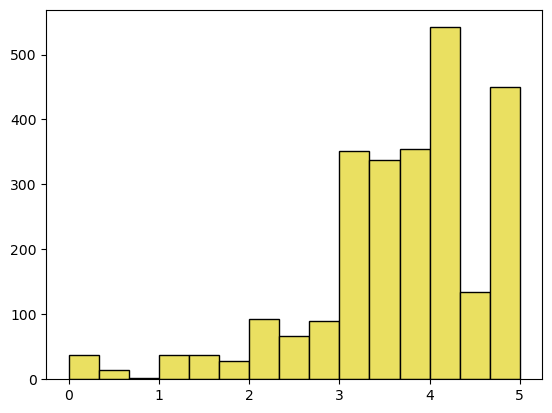

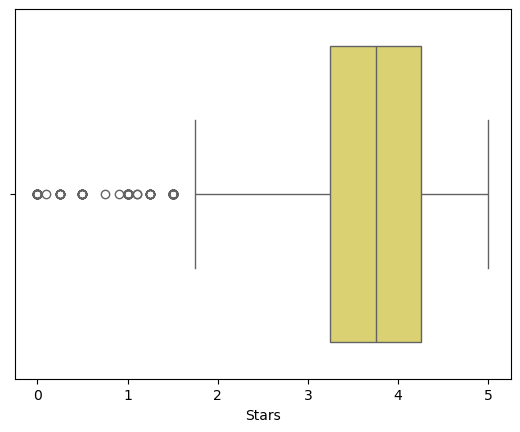

The average rating is 3.65 stars.
The median rating is 3.75 stars.
The standard deviation is 1.02 stars.
The lowest rating is 0.0 stars.
THe highest rating is 5.0 stars.


<Figure size 640x480 with 0 Axes>

In [294]:
# Converting the Stars column to a float since it's currently an object in Pandas

ramen.Stars = pd.to_numeric(ramen.Stars, errors = 'coerce')
ramen.dropna(subset = ['Stars'], axis = 0, inplace = True)
print("There are", ramen.Stars.isna().sum(), "null values.")

plt.hist(ramen.Stars, bins = 15, color = '#EAE061', edgecolor = 'black')
plt.show()
plt.clf()

sns.boxplot(x = ramen.Stars, color = '#EAE061')
plt.show()
plt.clf()

median_stars = ramen.Stars.median()
mean_stars = ramen.Stars.mean()
std_stars = ramen.Stars.std()


minimum_star_rating = ramen.Stars.min()
maximum_star_rating = ramen.Stars.max()

print("The average rating is", round(mean_stars, 2), "stars.")
print("The median rating is", round(median_stars, 2), "stars.")
print("The standard deviation is", round(std_stars, 2), "stars.")

print("The lowest rating is", round(minimum_star_rating, 2), "stars.")
print("THe highest rating is", round(maximum_star_rating, 2), "stars.")

In [295]:
#Average Ratings Grouped by Continent

ramen_reviewers = ramen.Country.unique()
regional_average_rating = ramen.groupby('Region').Stars.mean()
print(regional_average_rating)

Region
Africa           3.500000
Asia             3.746866
Europe           3.622340
North America    3.347756
Oceania          3.518373
South America    3.772727
Name: Stars, dtype: float64


In [296]:
print(ramen.groupby('Region').Region.count())

Region
Africa              2
Asia             1795
Europe             47
North America     390
Oceania           332
South America      11
Name: Region, dtype: int64


In [297]:
print(ramen.groupby('Style').Style.count())

Style
Bar        1
Bowl     481
Box        6
Can        1
Cup      450
Pack    1528
Tray     108
Name: Style, dtype: int64


In [298]:
style_averages = ramen.groupby('Style').Stars.mean()
print(style_averages)

Style
Bar     5.000000
Bowl    3.670686
Box     4.291667
Can     3.500000
Cup     3.498500
Pack    3.700458
Tray    3.545139
Name: Stars, dtype: float64


I conducted a multiple linear regression to examine how ramen characteristics influence overall ratings. The dependent variable is the reviewer’s overall rating, while the independent variables include flavor type, country of production, and packaging style. To avoid multicollinearity, one category from each set of dummies is used as the reference group:

Country: Oceania (reference)

Flavor: Other (non-chicken, beef, or pork)

Packaging: Pack ramen

This model allows us to estimate how each factor is associated with changes in ramen ratings relative to its respective baseline category.

In [300]:
# Multiple Linear Regression Model

x = ramen[['Bowl', 'Box', 'Can', 'Cup', 'Bar', 'Tray','Spicy', 'Chicken', 'Beef', 'Pork', 'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']]
y = ramen['Stars']


# Your columns
X = ramen[['Bowl','Box','Can','Cup','Bar','Tray',
           'North America','Africa','South America','Europe','Asia',
           'Spicy','Chicken','Beef','Pork']].copy()
y = ramen['Stars'].copy()

# 0) Normalize common string placeholders
X = X.replace(['', 'NA', 'N/A', 'None', '-', 'null'], np.nan)
y = y.replace(['', 'NA', 'N/A', 'None', '-', 'null'], np.nan)

for c in X.columns:
    if pd.api.types.is_bool_dtype(X[c]) or str(X[c].dtype) == 'boolean':
        X[c] = X[c].astype('float64')  # True/False/NA -> 1.0/0.0/NaN

obj_cols = [c for c in X.columns if X[c].dtype == 'O']
for c in obj_cols:
    s = X[c].astype(str).str.strip().str.lower()
    s = s.replace({'true':'1', 'false':'0', 't':'1', 'f':'0'})
    s = s.str.replace(',', '', regex=False) 
    X[c] = pd.to_numeric(s, errors='coerce')

X_np = X.to_numpy(dtype='float64')
X_np = sm.add_constant(X_np, has_constant='add')
y_np = y.to_numpy(dtype='float64')

feat_order = ['Bowl','Box','Can','Cup','Bar','Tray',
              'North America','Africa','South America','Europe','Asia',
              'Spicy','Chicken','Beef','Pork']

# Start from your numeric X (without const):
X_df = pd.DataFrame(X, columns=feat_order).astype('float64')

# Now add the const (once)
X_df = sm.add_constant(X_df, has_constant='add')

model = sm.OLS(y.astype('float64'), X_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stars   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6.358
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           1.87e-13
Time:                        00:34:42   Log-Likelihood:                -3648.2
No. Observations:                2577   AIC:                             7328.
Df Residuals:                    2561   BIC:                             7422.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.6151      0.059     61.674

Based on this multiple linear regression model, we see that there's a positive correlation between whether a product in made in Asia or not and the corresponding number of stars that ramen product received. There's a negative relationship between chicken, beef, and pork flavors and their corresponding ramen ratings as there is a negative coefficient for each flavor. 

I then conducted an Analysis of Variance (ANOVA) test to see if the rating were substantially different between continents from which the ratings were given. The null hypothesis would be that ratings are the same across regions with our alternative hypothesis that there is some variation across the globe. 

In [302]:
# ANOVA evaluating average ratings by continent

north_america_ratings = ramen.Stars[ramen.Region == 'North America']
south_america_ratings = ramen.Stars[ramen.Region == 'South America']
europe_ratings = ramen.Stars[ramen.Region == 'Europe']
africa_ratings = ramen.Stars[ramen.Region == 'Africa']
asia_ratings = ramen.Stars[ramen.Region == 'Asia']
oceania_ratings = ramen.Stars[ramen.Region == 'Oceania']

f_stat, p_val = f_oneway(north_america_ratings, south_america_ratings, europe_ratings, africa_ratings, asia_ratings, oceania_ratings)

print('f-stat:', f_stat)
print('p_value', p_val)

f-stat: 11.56464674893
p_value 4.564468592903681e-11


Given that our p-value has met the alpha threshold of 0.05, we are able to conclude that there is variation on an inter-continental level. Now it's time to look at which regions this variation is present. 

In [303]:
tukey = pairwise_tukeyhsd(endog = ramen.Stars, groups = ramen.Region, alpha = 0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
       Africa          Asia   0.2469 0.9993 -1.7811  2.2748  False
       Africa        Europe   0.1223    1.0 -1.9471  2.1918  False
       Africa North America  -0.1522 0.9999 -2.1842  1.8798  False
       Africa       Oceania   0.0184    1.0 -2.0145  2.0513  False
       Africa South America   0.2727 0.9993 -1.9306  2.4761  False
         Asia        Europe  -0.1245 0.9603 -0.5481   0.299  False
         Asia North America  -0.3991    0.0 -0.5592  -0.239   True
         Asia       Oceania  -0.2285  0.002 -0.3997 -0.0573   True
         Asia South America   0.0259    1.0  -0.841  0.8927  False
       Europe North America  -0.2746 0.4859 -0.7172   0.168  False
       Europe       Oceania   -0.104 0.9858 -0.5507  0.3427  False
       Europe South America   0.1504 0.9978 -0.8097  1.1104  F

Here, we can see that there's a statistically significant difference in ratings overall between Asia and North America and Asia and Oceania while the relationship between other pairs remains inconclusive. 